## 正方格子状に並んだ4qubitをパルスレベルハミルトニアンを用いて操作するコード

### モジュールのインポート

In [1]:
"""モジュールのインポート"""
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from lib.H_gen_module import H_gen
from scipy import optimize
from qutip import tensor, sigmap, sigmam, sigmax, sigmay, sigmaz, qeye, mesolve, sesolve, basis, identity
from qutip.qip.circuit import QubitCircuit
from qutip.solver import Options, Result
from qutip.measurement import measure, measure_povm, measurement_statistics_povm
from qutip.states import ket2dm

### パラメータ設定とSW変換後のパラメータ計算

In [2]:
"""パラメータ設定"""
# qubit数
nqubits = 4

# qubitの周波数
w_q0 = 7555e6 # Hz qubit0周波数
w_q1 = 8300e6 # Hz qubit1周波数
w_q2 = 7400e6 # Hz qubit2周波数
w_q3 = 7700e6 # Hz qubit3周波数
w_q = [w_q0*2*np.pi, w_q1*2*np.pi, w_q2*2*np.pi, w_q3*2*np.pi] # qubit周波数リスト

# qubitの非調和度
a_0 = 250e6 # Hz qubit0の非調和度
a_1 = 260e6 # Hz qubit1の非調和度
a_2 = 255e6 # Hz qubit2の非調和度
a_3 = 253e6 # Hz qubit3の非調和度
a = [a_0*2*np.pi, a_1*2*np.pi, a_2*2*np.pi, a_3*2*np.pi] # qubit非調和度リスト

# 結合のペア
bond = [[int(i), int((i+1)%4)] for i in range(nqubits)]

# 結合定数
g_01 = -0.6e8  # Hz qubit0-1の結合定数
g_12 = -0.62e8 # Hz qubit1-2の結合定数
g_23 = -0.63e8 # Hz qubit2-3の結合定数
g_30 = -0.60e8 # Hz qubit3-0の結合定数
g = [g_01, g_12, g_23, g_30] # 結合定数リスト
# g = [0.0, 0.0, 0.0, 0.0] # 隣接qubitの結合をきってみる

# qubit-transmission lineの外部損失
r_q0 = 6.28e3 # Hz qubit0の外部損失
r_q1 = 6.28e3 # Hz qubit1の外部損失
r_q2 = 6.28e3 # Hz qubit2の外部損失
r_q3 = 6.28e3 # Hz qubit3の外部損失
r = [r_q0, r_q1, r_q2, r_q3] # 外部損失リスト

# 隣接qubit(正方向 0 → 1)の周波数差
d_01 = w_q0 - w_q1 # qubit0, 1の周波数差(w_q0 - w_q1)
d_12 = w_q1 - w_q2 # qubit1, 2の周波数差(w_q1 - w_q2)
d_23 = w_q2 - w_q3 # qubit2, 3の周波数差(w_q2 - w_q3)
d_30 = w_q3 - w_q0 # qubit3, 0の周波数差(w_q3 - w_q0)
d_p = [d_01*2*np.pi, d_12*2*np.pi, d_23*2*np.pi, d_30*2*np.pi] # 正方向周波数差リスト

# 隣接qubit(負方向 1 → 0)の周波数差
d_10 = w_q1 - w_q0
d_21 = w_q2 - w_q1
d_32 = w_q3 - w_q2
d_03 = w_q0 - w_q3
d_m = [d_10*2*np.pi, d_21*2*np.pi, d_32*2*np.pi, d_03*2*np.pi] # 負方向周波数差リスト


"""Schrieffer-Wolf変換後のパラメータ計算"""
# SW変換後のξの計算
xi=[]
for i in range(len(bond)):
    xi_i = g[i]**2 * (a[bond[i][0]] + a[bond[i][1]]) / ((d_p[i] + a[bond[i][0]]) * (d_p[i] - a[bond[i][1]])) / 2
    xi.append(xi_i)
    # ksi.append(0) # 残留ZZなしでsimulationする場合

# SW変換後のν(正方向 0 → 1)の計算
nu_p=[]
for i in range(nqubits):
    nu_i = g[i] / (d_p[i] + a[bond[i][0]])
    nu_p.append(nu_i)

# SW変換後のν(負方向 1 → 0)の計算
nu_m=[]
for i in range(nqubits):
    nu_i = g[i] / (d_m[i] + a[bond[i][1]])
    nu_m.append(nu_i)

# SW変換後のμ(正方向 0 → 1)の計算
mu_p=[]
for i in range(nqubits):
    mu_i = g[i]*a[bond[i][0]] / (d_p[i]*(d_p[i] + a[bond[i][0]]))
    mu_p.append(mu_i)

# SW変換後のμ(正方向 0 → 1)の計算
mu_m=[]
for i in range(nqubits):
    mu_i = g[i]*a[bond[i][1]] / (d_m[i]*(d_m[i] + a[bond[i][1]]))
    mu_m.append(mu_i)

# SW変換後のqubit周波数
w_tilde=[]
for i in range(nqubits):
    bond_list=[]
    w_tilde_i=w_q[i]
    for j in range(len(bond)):
        if bond[j][0] == i:
            bond_list.append(j)
        elif bond[j][1] == i:
            bond_list.append(-j)
    for k in bond_list:
        if k >= 0:
            w_tilde_i += (g[k]**2 / d_p[k])
            w_tilde_i += xi[k]
        if k < 0:
            w_tilde_i -= (g[k]**2 / d_p[k])
            w_tilde_i += xi[k]
    w_tilde.append(w_tilde_i)

### 測定オペレータの定義

In [3]:
"""povmオペレータの定義（Z基底の射影測定）"""
ket_0 = ket2dm(basis(2, 0))
ket_1 = ket2dm(basis(2, 1))
povm=[]
for i in range(2**nqubits):
    bin = format(i, f"0{nqubits}b")
    m=[]
    for j in range(nqubits):
        if bin[j] == "0":
            m.append(ket_0)
        elif bin[j] == "1":
            m.append(ket_1)
    M = m[0]
    for k in range(len(m)-1):
        M = tensor(M, m[k+1])   
    povm.append(M)


"""期待値測定オペレータの定義（パウリテンソル積の全ての組）"""
e_ops=[]
for i in range(nqubits):
    X_e_ops = [qeye(2) for _ in range(nqubits)]
    Y_e_ops = [qeye(2) for _ in range(nqubits)]
    Z_e_ops = [qeye(2) for _ in range(nqubits)]
    X_e_ops[i] = sigmax()
    Y_e_ops[i] = sigmay()
    Z_e_ops[i] = sigmaz()
    e_ops.append(tensor(X_e_ops))
    e_ops.append(tensor(Y_e_ops))
    e_ops.append(tensor(Z_e_ops))

### メインコード

In [4]:
"""パルスレベルハミルトニアンによる時間発展を計算し、期待値を返す関数"""

def State(f, A, phi, T):
    """
    Parameters
    ----------
    f : list
        drive frequency for n qubits [MHz]

    A : list
        drive amplitude for n qubits [Hz]

    phi : list
        drive phase for n qubits [rad]

    T : float
        drive time [s]

    Returns
    -------
    expectation value list of n qubits
    
    """

    # 時間刻み
    t_list = np.linspace(0, T, 1000)

    # 角速度ωを定義(入力はfなので2πかけて)
    w = [f[i]*1e6*2*np.pi for i in range(nqubits)] # Hz

    # ドライブパワーΩの計算
    Omega = [np.sqrt(r[i]) * A[i] for i in range(nqubits)] # Hz
    
    # 初期状態準備
    tensor_list = [basis(2, 0) for _ in range(nqubits)]
    state = tensor(tensor_list)
    
    # ハミルトニアンの構築
    H_td=[]
    for j in range(nqubits):
        # 時間依存ハミルトニアン
        H = H_gen(nqubits=nqubits, pair=bond[j], g=g, d_p=d_p, d_m=d_m, w=w, w_tilde=w_tilde, xi=xi, nu_p=nu_p, nu_m=nu_m, mu_p=mu_p, mu_m=mu_m, phi=phi, Omega=Omega) #インスタンス生成
        H_td += H.H_td_list()

    # 残留ZZハミルトニアン（時間無依存ハミルトニアン）
    H_res = xi[0]/4*tensor(sigmaz(), sigmaz(), qeye(2), qeye(2)) + xi[1]/4*tensor(qeye(2), sigmaz(), sigmaz(), qeye(2)) + xi[2]/4*tensor(qeye(2), qeye(2), sigmaz(), sigmaz()) + xi[3]/4*tensor(sigmaz(), qeye(2), qeye(2), sigmaz())

    # 全ハミルトニアンを定義
    H_all = [H_res]
    H_all += H_td

    # 定義したハミルトニアンで時間発展
    result = sesolve(H_all, state, t_list, e_ops=e_ops)

    # #POVM測定
    # proj_result, proj_state = measure_povm(state, povm)

    return result.expect[0], result.expect[1], result.expect[2], result.expect[3], result.expect[4], result.expect[5], result.expect[6], result.expect[7], result.expect[8], result.expect[9], result.expect[10], result.expect[11]

### パルスレベルハミルトニアンのパラメータと時間を決めてシミュレーション

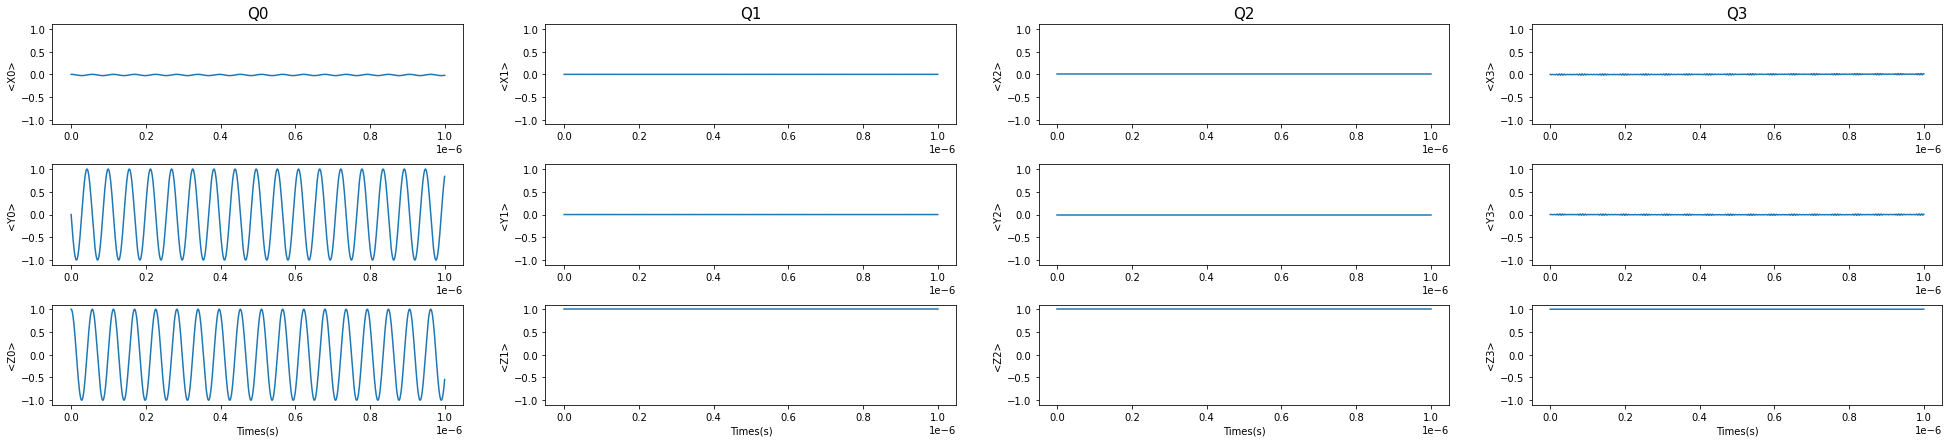

In [5]:
"""1 qubit gate"""
# qubit0 X軸回転パルス
f_X0 = [w_tilde[0]/1e6/(2*np.pi), 0, 0, 0]
A_X0 = [7e5, 0.0, 0.0, 0.0]
phi_X0 = [0, 0, 0, 0]
            
# qubit1へのX軸回転パルス
f_X1 = [0.0, w_tilde[1]/1e6/(2*np.pi), 0.0, 0.0]
A_X1 = [0.0, 7e5, 0.0, 0.0]
phi_X1 = [0, 0, 0.0, 0]


"""2 qubit gate"""
# qubit0→1のCRゲート
f_CR01 = [w_tilde[1]/1e6/(2*np.pi), 0, 0, 0]
A_CR01 = [50e5, 0.0, 0.0, 0.0]
phi_CR01 = [0, 0, 0, 0]

# qubit0→1の-CRゲート
f_CR01_m = [w_tilde[1]/1e6/(2*np.pi), 0, 0, 0]
A_CR01_m = [50e5, 0.0, 0.0, 0.0]
phi_CR01_m = [np.pi, 0, 0, 0]

# qubit1→0のCRゲート
f_CR10 = [0, w_tilde[0]/1e6/(2*np.pi), 0, 0]
A_CR10 = [0, 50e5, 0.0, 0.0]
phi_CR10 = [0, 0, 0, 0]

# qubit1→2のCRゲート
f_CR12 = [0, w_tilde[2]/1e6/(2*np.pi), 0, 0]
A_CR12 = [0, 60e5, 0.0, 0.0]
phi_CR12 = [0, 0, 0, 0]


"""時間パラメータの設定"""
T = 1000e-9 # [s] どれだけ時間発展させるか
t_list = np.linspace(0, T, 1000) # Tによって刻み幅はもっと細かくする必要がある。ODEエラーが出た時。


"""シミュレーション"""
X0, Y0, Z0, X1, Y1, Z1, X2, Y2, Z2, X3, Y3, Z3 = State(f_X0, A_X0, phi_X0, T)


"""期待値の描画"""
fig, axes = plt.subplots(figsize=(30, 7), ncols=nqubits, nrows=3)

# qubit0
axes[0,0].plot(t_list, X0)
axes[0,0].set_title("Q0", fontsize=15)
axes[0,0].set_ylim(-1.1, 1.1)
axes[0,0].set_ylabel("<X0>")

axes[1,0].plot(t_list, Y0)
axes[1,0].set_ylim(-1.1, 1.1)
axes[1,0].set_ylabel("<Y0>")

axes[2,0].plot(t_list, Z0)
axes[2,0].set_ylim(-1.1, 1.1)
axes[2,0].set_xlabel("Times(s)")
axes[2,0].set_ylabel("<Z0>")

# qubit1
axes[0,1].plot(t_list, X1)
axes[0,1].set_title("Q1", fontsize=15)
axes[0,1].set_ylim(-1.1, 1.1)
axes[0,1].set_ylabel("<X1>")

axes[1,1].plot(t_list, Y1)
axes[1,1].set_ylim(-1.1, 1.1)
axes[1,1].set_ylabel("<Y1>")

axes[2,1].plot(t_list, Z1)
axes[2,1].set_ylim(-1.1, 1.1)
axes[2,1].set_xlabel("Times(s)")
axes[2,1].set_ylabel("<Z1>")

# qubit2
axes[0,2].plot(t_list, X2)
axes[0,2].set_title("Q2", fontsize=15)
axes[0,2].set_ylim(-1.1, 1.1)
axes[0,2].set_ylabel("<X2>")

axes[1,2].plot(t_list, Y2)
axes[1,2].set_ylim(-1.1, 1.1)
axes[1,2].set_ylabel("<Y2>")

axes[2,2].plot(t_list, Z2)
axes[2,2].set_ylim(-1.1, 1.1)
axes[2,2].set_xlabel("Times(s)")
axes[2,2].set_ylabel("<Z2>")

# qubit3
axes[0,3].plot(t_list, X3)
axes[0,3].set_title("Q3", fontsize=15)
axes[0,3].set_ylim(-1.1, 1.1)
axes[0,3].set_ylabel("<X3>")

axes[1,3].plot(t_list, Y3)
axes[1,3].set_ylim(-1.1, 1.1)
axes[1,3].set_ylabel("<Y3>")

axes[2,3].plot(t_list, Z3)
axes[2,3].set_ylim(-1.1, 1.1)
axes[2,3].set_xlabel("Times(s)")
axes[2,3].set_ylabel("<Z3>")

plt.subplots_adjust(right=1.0)
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.4)
plt.show()


## メモ
#### ・CRはqubitのペアごとに最適なパワーΩは変わるので注意する。tan^-1(Ω/Δ)が36°を超えないようにする。